# Análise do Catálogo da Netflix

Alexandre Souza - 12559506

Eduardo Zaffari Monteiro - 12559490

Lucas Ivars Cadima Ciziks - 12559472

## Introdução
Em 2021, a indústria de entretenimento audiovisual provou que conseguiu superar a pandemia do COVID-19 no que tange ao seu faturamento total. Segundo o relatório anual da Motion Picture Association (MPA), no ano passado foram arrecadados US$ 99,7 bilhões, número que supera os US$ 98,1 bilhões de 2019, ano anterior à crise sanitária. 

Da arrecadação total, 72% refere-se ao consumo de mídia digital, o equivalente a US$ 71,9 bilhões, impulsionado pelos serviços de mídia digital (serviços de *streaming* e *TV Everywhere*), que contavam com mais de 1,3 bilhão de assinaturas ativas no último ano, das quais 221,6 milhões eram da Netflix.

Em se tratando da Netflix, que hoje possui 45,2% da fatia de mercado de serviços de *streaming*, aproximadamente 17,8% de suas assinaturas são da América Latina, contra os 33,2% da EMEA, região que corresponde a Europa, Oriente Médio e África. Contudo, ainda segundo o relatório da MPA, o mercado de serviços digitais aumentou 29% nos países latino-americanos em 2021 (quando comparado a 2020), em contraste com os  21% da região comercial EMEA.

Tendo isso em vista, o objetivo deste relatório é tentar provar, por meio da análise exploratória dos dados e teste de hipóteses, que houve maior investimento em produções de origem europeia em detrimento das de origem latino-americana, explicitando a desigualdade cultural entre as duas regiões.

## Desenvolvimento

In [33]:
# Realizando importação de Bibliotecas
import pandas as pd
import numpy as np
import json
from scipy import stats
import seaborn as sns

### Coleta e Limpeza dos dados

In [12]:
# Carregando Dados referentes ao Catálogo da Netflix
netflix_raw = pd.read_csv('https://raw.githubusercontent.com/Cizika/netflix-analysis/main/netflix_titles.csv', index_col=0)
netflix_raw.head()

,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
show_id,,,,,,,,,,,
s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [13]:
# Carregando Dados de países/continentes
with open('countries.json') as json_file:
    countries = json.load(json_file)

In [14]:
# Lista de países europeus
european_list = countries["Europe"]["countries"]
european_list

['Albania',
 'Andorra',
 'Åland',
 'Austria',
 'Belarus',
 'Belgium',
 'Bosnia and Herzegovina',
 'Bulgaria',
 'Croatia',
 'Cyprus',
 'Czech Republic',
 'Denmark',
 'Estonia',
 'Faroe Islands',
 'Finland',
 'France',
 'Germany',
 'Gibraltar',
 'Greece',
 'Greenland',
 'Guernsey',
 'Hungary',
 'Iceland',
 'Ireland',
 'Isle of Man',
 'Israel',
 'Italy',
 'Jersey',
 'Latvia',
 'Liechtenstein',
 'Lithuania',
 'Luxembourg',
 'Macedonia',
 'Malta',
 'Moldova',
 'Monaco',
 'Montenegro',
 'Netherlands',
 'Norway',
 'Poland',
 'Romania',
 'Russia',
 'Serbia',
 'Spain',
 'Sweden',
 'Switzerland',
 'Slovakia',
 'Slovenia',
 'Svalbard and Jan Mayen',
 'San Marino',
 'Ukraine',
 'United Kingdom']

In [15]:
# Lista de países latinos
latin_list = countries["Latin America"]["countries"]
latin_list

['Costa Rica',
 'Cuba',
 'Haiti',
 'Panama',
 'Saint Bartélemy',
 'El Salvador',
 'Saint Martin',
 'Argentina',
 'Belize',
 'Bolivia',
 'Brazil',
 'Chile',
 'Colombia',
 'Ecuador',
 'Dominican Republic',
 'Guatemala',
 'Honduras',
 'Mexico',
 'Nicaragua',
 'Paraguay',
 'Peru',
 'Puerto Rico',
 'Uruguay',
 'Venezuela']

In [16]:
# Excluindo NAs
netflix_df = netflix_raw[["country","date_added"]].dropna()

# Coletando somente o ano de adição dos filmes ao catálogo
netflix_df["year_added"] = netflix_df["date_added"].apply(lambda x: int(x.split(", ")[1]))

netflix_df

,country,date_added,year_added
show_id,,,
s1,United States,"September 25, 2021",2021
s2,South Africa,"September 24, 2021",2021
s5,India,"September 24, 2021",2021
s8,"United States, Ghana, Burkina Faso, United Kin...","September 24, 2021",2021
s9,United Kingdom,"September 24, 2021",2021
...,...,...,...
s8802,"United Arab Emirates, Jordan","March 9, 2016",2016
s8803,United States,"November 20, 2019",2019
s8805,United States,"November 1, 2019",2019


### Coletando Amostra

In [17]:
# Coletando amostra dos filmes adicionados em 2021
amostra_raw = netflix_df[netflix_df["year_added"] == 2021].copy()

# Individualizando país por linha
amostra_raw = amostra_raw.assign(country=amostra_raw["country"].str.split(", ")).explode("country")

amostra_raw

,country,date_added,year_added
show_id,,,
s1,United States,"September 25, 2021",2021
s2,South Africa,"September 24, 2021",2021
s5,India,"September 24, 2021",2021
s8,United States,"September 24, 2021",2021
s8,Ghana,"September 24, 2021",2021
...,...,...,...
s8321,Sweden,"January 5, 2021",2021
s8321,Norway,"January 5, 2021",2021
s8435,United States,"January 1, 2021",2021


In [18]:
# Calculando Número de Filmes por País
amostra = amostra_raw.groupby("country").size().to_frame()
amostra.drop("", inplace=True)
amostra.reset_index(inplace=True)
amostra.rename(columns={"country":"País", 0: "Número de Filmes" }, inplace=True)

amostra

,País,Número de Filmes
0,Algeria,1
1,Argentina,12
2,Australia,24
3,Austria,1
4,Bangladesh,1
...,...,...
67,"United Kingdom,",1
68,United States,627
69,Uruguay,2
70,Venezuela,1


In [19]:
# Dicotomizando por Variável Qualitativa is_latin e is_european
amostra["Latino"] = amostra["País"].isin(latin_list)
amostra["Europeu"] = amostra["País"].isin(european_list)

amostra

,País,Número de Filmes,Latino,Europeu
0,Algeria,1,False,False
1,Argentina,12,True,False
2,Australia,24,False,False
3,Austria,1,False,True
4,Bangladesh,1,False,False
...,...,...,...,...
67,"United Kingdom,",1,False,False
68,United States,627,False,False
69,Uruguay,2,True,False
70,Venezuela,1,True,False


### Análise Exploratória dos Dados

In [66]:
amostra.describe()

,Número de Filmes
count,72.000000
mean,20.416667
std,75.638084
min,1.000000
25%,1.000000
50%,4.000000
75%,9.500000
max,627.000000


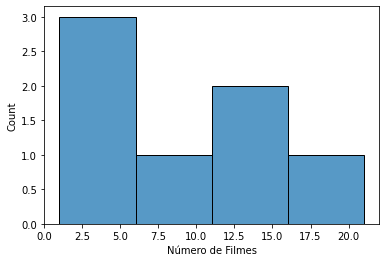

In [65]:
# Montando Boxplot com dados da Amostra
# Foi removido o outlier dos EUA (637) para facilitar a visualização
# sns.boxplot(data=]["Número de Filmes"])
# amostra.where(amostra["Latino"] == True or amostra["Europeu"] == True)
latinos = amostra[amostra["Latino"] == True]
latinos["Número de Filmes"]
sns.histplot(data=latinos["Número de Filmes"])

### Teste de Normalidade

#### Teste de Shapiro-Wilk

In [71]:
# Realizando Teste de Normalidade do Número de Filmes através do Teste de Shapiro
shapiro_test = stats.shapiro(amostra[(amostra["Latino"]) | (amostra["Europeu"])]["Número de Filmes"])
print(shapiro_test)
if shapiro_test[1] < 0.05:
  print("Há evidências para recusar a normalidade")
else:
  print("Há evidências para não recusar a normalidade")

(0.5183895230293274, 5.861419349884045e-09)
Há evidências para recusar a normalidade


In [77]:
transformados = stats.boxcox(amostra["Número de Filmes"])
# stats.shapiro(np.asarray(transformados))
# np.(transformados)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


array([array([0.        , 1.77977753, 2.08920293, 0.        , 0.        ,
              1.6322589 , 1.73643022, 0.62888869, 0.        , 0.        ,
              0.        , 2.40946101, 0.        , 0.62888869, 2.01365028,
              1.6322589 , 1.14489425, 1.29043647, 1.49309443, 0.        ,
              0.62888869, 2.41469724, 2.28109642, 0.        , 0.        ,
              1.40266118, 0.94304558, 0.        , 2.57544736, 1.81871364,
              1.29043647, 1.29043647, 1.9156674 , 2.37545076, 0.        ,
              0.        , 0.        , 1.40266118, 0.        , 0.        ,
              0.        , 2.03425537, 0.        , 1.29043647, 1.40266118,
              2.15008499, 0.94304558, 0.        , 1.29043647, 1.40266118,
              0.62888869, 0.94304558, 1.29043647, 1.14489425, 0.62888869,
              0.94304558, 1.6322589 , 2.16357405, 2.21209435, 1.14489425,
              0.94304558, 0.62888869, 1.6322589 , 1.6322589 , 2.12115016,
              1.14489425, 2.6080204 , 

### Teste para Comparação de Médias entre Duas Populações Independentes

Definindo as seguintes Variáveis Aleatórias para realizar os Teste:

$L: $ Número de filmes produzidos por países latinos no catálogo da Netflix;

$E: $ Número de filmes produzidos por países europeus no catálogo da Netflix.

Considerando a **média populacional** de filmes produzidos por país latino como $\mu_L$ e a **média populacional** de filmes produzidos por país europeu como $\mu_E$. Para a comparação das médias, define-se a estatística $\overline{D}$ tal que:

$$\overline{D} = \overline{L} - \overline{E} \sim N\left(\mu_D = \mu_L - \mu_E, \sigma^2_D = \frac{\sigma^2_L}{n_L} + \frac{\sigma^2_E}{n_E} \right)$$

Assim, considera-se o seguinte teste de hipóteses:

*   $H_0: \mu_D = \delta$ contra
*   $H_1: \mu_D \neq \delta$, com $\delta$ constante.

In [86]:
# Calculando a média de filmes por País da América Latina
mean_latinos = amostra[amostra["Latino"]]["Número de Filmes"].mean()

print(f"Em 2021, cada país latino produziu, em média, {mean_latinos} filmes.")

# Calculando a média de filmes por País da Europa
mean_europa = amostra[amostra["Europeu"]]["Número de Filmes"].mean()

print(f"Em 2021, cada país europeu produziu, em média, {mean_europa} filmes.")

Em 2021, cada país latino produziu, em média, 8.285714285714286 filmes.
Em 2021, cada país europeu produziu, em média, 14.041666666666666 filmes.


In [87]:
# Calculando Variância Amostral dos Latinos
var_latinos = amostra[amostra["Latino"]]["Número de Filmes"].var()

print(f"Em 2021, a variância amostral encontrada para os países latinos foi {var_latinos}.")

# Calculando Variância Amostral dos Europeus
var_europeus = amostra[amostra["Europeu"]]["Número de Filmes"].var()

print(f"Em 2021, a variância amostral encontrada para os países europeus foi {var_europeus}.")

Em 2021, a variância amostral encontrada para os países latinos foi 52.57142857142858.
Em 2021, a variância amostral encontrada para os países europeus foi 708.8242753623188.
